In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as trans_f

sys.path.append(os.path.abspath(sys.path[0] + '/../../'))
__package__ = "deep_view_syn.notebook"
torch.cuda.set_device(2)
print("Set CUDA:%d as current device." % torch.cuda.current_device())

from ..data.spherical_view_syn import *
from ..configs.spherical_view_syn import SphericalViewSynConfig
from ..my import netio
from ..my import util
from ..my import device
from ..my import view
from ..my import refine
from ..my.simple_perf import SimplePerf
from ..my.foveation import Foveation


def load_net(path):
    config = SphericalViewSynConfig()
    config.from_id(path[:-4])
    config.SAMPLE_PARAMS['perturb_sample'] = False
    config.print()
    net = config.create_net().to(device.GetDevice())
    netio.LoadNet(path, net)
    return net


def find_file(prefix):
    for path in os.listdir():
        if path.startswith(prefix):
            return path
    return None


def load_views(data_desc_file) -> view.Trans:
    with open(data_desc_file, 'r', encoding='utf-8') as file:
        data_desc = json.loads(file.read())
        samples = data_desc['samples'] if 'samples' in data_desc else [-1]
        view_centers = torch.tensor(
            data_desc['view_centers'], device=device.GetDevice()).view(samples + [3])
        view_rots = torch.tensor(
            data_desc['view_rots'], device=device.GetDevice()).view(samples + [3, 3])
        return view.Trans(view_centers, view_rots)


def read_ref_images(idx):
    patt = 'ref/view_%04d.png'
    if isinstance(idx, torch.Tensor) and len(idx.size()) > 0:
        return util.ReadImageTensor([patt % i for i in idx])
    else:
        return util.ReadImageTensor(patt % idx)


def adjust_cam(cam, vr_cam, gaze_center):
    fovea_offset = (
        (gaze_center[0]) / vr_cam.f[0].item() * cam.f[0].item(),
        (gaze_center[1]) / vr_cam.f[1].item() * cam.f[1].item()
    )
    cam.c[0] = cam.res[1] / 2 - fovea_offset[0]
    cam.c[1] = cam.res[0] / 2 - fovea_offset[1]


Set CUDA:2 as current device.


In [2]:
#os.chdir(sys.path[0] + '/../data/us_gas_all_in_one')
#os.chdir(sys.path[0] + '/../data/us_mc_all_in_one')
os.chdir(sys.path[0] + '/../data/bedroom_all_in_one')
print('Change working directory to ', os.getcwd())
torch.autograd.set_grad_enabled(False)

fovea_net = load_net(find_file('fovea'))
periph_net = load_net(find_file('periph'))

# Load Dataset
views = load_views('views.json')
#ref_dataset = SphericalViewSynDataset('ref.json', load_images=False, calculate_rays=False)
print('Dataset loaded.')

print('views:', views.size())
#print('ref views:', ref_dataset.samples)

Change working directory to  /home/dengnc/deep_view_syn/data/bedroom_all_in_one
==== Config fovea ====
Net type:  nmsl
Encode dim:  10
Optimizer decay:  0
Normalize:  False
Direction as input:  False
Full-connected network parameters: {'nf': 256, 'n_layers': 4, 'skips': []}
Sample parameters {'spherical': True, 'depth_range': (1.0, 50.0), 'n_samples': 32, 'perturb_sample': False, 'lindisp': True, 'inverse_r': True}
Load net from fovea@nmsl-rgb_e10_fc256x4_d1.00-50.00_s32.pth ...
==== Config periph ====
Net type:  nnmsl
Encode dim:  10
Optimizer decay:  0
Normalize:  False
Direction as input:  False
Full-connected network parameters: {'nf': 64, 'n_layers': 4, 'skips': []}
Sample parameters {'spherical': True, 'depth_range': (1.0, 50.0), 'n_samples': 16, 'perturb_sample': False, 'lindisp': True, 'inverse_r': True}
Load net from periph@nnmsl-rgb_e10_fc64x4_d1.00-50.00_s16.pth ...
Dataset loaded.
views: [5, 5, 5, 5, 5]


view_coord: [2, 2, 2, 2, 2]
Get rays: 2.9ms
Infer fovea: 40.5ms
torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 230])
Infer mid & periph: 69.6ms
Infer: 112.1ms
Refine: 3.7ms
232.5
99.0
Blend: 3.6ms
Get rays: 3.5ms
Infer fovea: 44.2ms
torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 230])
Infer mid & periph: 70.7ms
Infer: 119.7ms
Refine: 0.1ms
232.5
99.0
Blend: 2.1ms


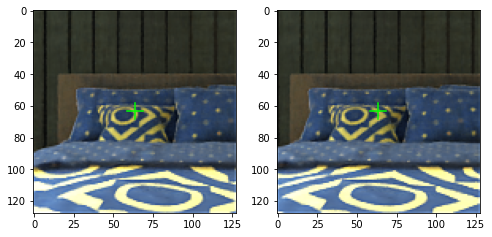

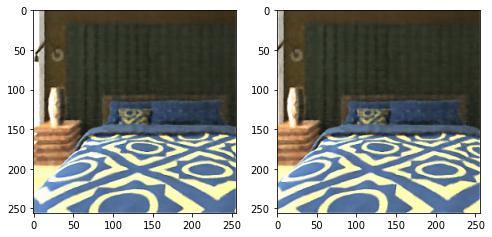

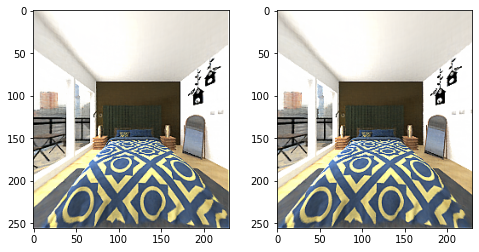

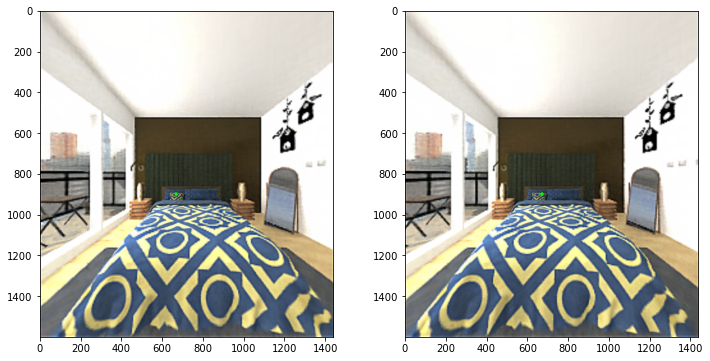

In [5]:
#==gas==
#set_id = 0
#left_center = (-137, 64)
#right_center = (-142, 64)
#set_id = 1
#left_center = (133, -44)
#right_center = (130, -44)
#set_id = 2
#left_center = (-20, -5)
#right_center = (-25, -5)
#==mc==
#set_id = 3
#left_center = (-107, 80)
#right_center = (-112, 80)
#set_id = 4
#left_center = (-17, -90)
#right_center = (-22, -90)
#set_id = 5
#left_center = (95, 30)
#right_center = (91, 30)
#==bedroom==
set_id = 0
left_center = (-50, 100)
right_center = (-50, 100)
view_coord = [0, 0, 0, 0, 0]
fovea_postprocess = 'none'  # 'upscale_refine', 'none'
constrast_refine = True

for i, val in enumerate(views.size()):
    view_coord[i] += val // 2
print('view_coord:', view_coord)
test_view = views.get(*view_coord)

fov_list = [20, 45, 110]
res_list = [(128, 128), (256, 256), (256, 230)]  # (192,256)]
res_full = (1600, 1440)
cams = [
    view.CameraParam({
        "fov": fov_list[i],
        "cx": 0.5,
        "cy": 0.5,
        "normalized": True
    }, res_list[i]).to(device.GetDevice())
    for i in range(len(fov_list))
]
fovea_cam, mid_cam, periph_cam = cams[0], cams[1], cams[2]
#guide_cam = ref_dataset.cam_params
vr_cam = view.CameraParam({
    'fov': fov_list[-1],
    'cx': 0.5,
    'cy': 0.5,
    'normalized': True
}, res_full)
foveation = Foveation(fov_list, res_full, device=device.GetDevice())

def get_guides(view_coord):
    coord_offset = [val // 2 - views.size()[i] // 2 for i, val in enumerate(ref_dataset.samples)]
    guides_coord = [
        [
            view_coord[0] - 2, view_coord[1] + 2, view_coord[2],
            view_coord[3] - 1, view_coord[4] + 1
        ],
        [
            view_coord[0] + 2, view_coord[1] + 2, view_coord[2],
            view_coord[3] + 1, view_coord[4] + 1
        ],
        [
            view_coord[0] - 2, view_coord[1] - 2, view_coord[2],
            view_coord[3] - 1, view_coord[4] - 1
        ],
        [
            view_coord[0] + 2, view_coord[1] - 2, view_coord[2],
            view_coord[3] + 1, view_coord[4] - 1
        ]
    ]
    for coord in guides_coord:
        for i in range(len(coord_offset)):
            coord[i] += coord_offset[i]
    ref_indices = torch.arange(0, ref_dataset.n_views,
                               device=device.GetDevice()).view(ref_dataset.samples)
    guides_idx = torch.stack([
        ref_indices[tuple(coord)] for coord in guides_coord
    ])
    guides_image = read_ref_images(guides_idx).to(device.GetDevice())
    guides_trans = view.Trans(ref_dataset.view_centers[guides_idx],
                              ref_dataset.view_rots[guides_idx])
    return refine.GuideRefinement(guides_image, guides_trans, guide_cam, fovea_net)


if fovea_postprocess.find('refine') >= 0:
    guide_refine = get_guides(view_coord)
else:
    guide_refine = None

def gen(fovea_center, trans):
    adjust_cam(fovea_cam, vr_cam, fovea_center)
    adjust_cam(mid_cam, vr_cam, fovea_center)

    perf = SimplePerf(True, True)

    fovea_rays_o, fovea_rays_d = fovea_cam.get_global_rays(
        trans)  # (H_fovea, W_fovea, 3)
    mid_rays_o, mid_rays_d = mid_cam.get_global_rays(
        trans)  # (H_mid, W_mid, 3)
    periph_rays_o, periph_rays_d = periph_cam.get_global_rays(
        trans)  # (H_periph, W_periph, 3)
    mid_periph_rays_o = torch.cat(
        [mid_rays_o.view(-1, 3), periph_rays_o.view(-1, 3)], 0)
    mid_periph_rays_d = torch.cat(
        [mid_rays_d.view(-1, 3), periph_rays_d.view(-1, 3)], 0)
    perf.Checkpoint('Get rays')

    perf1 = SimplePerf(True, True)

    fovea_inferred, fovea_depthmap = fovea_net(
        fovea_rays_o.view(-1, 3), fovea_rays_d.view(-1, 3), ret_depth=True)
    fovea_inferred = fovea_inferred.view(
        1, fovea_cam.res[0], fovea_cam.res[1], -1).permute(0, 3, 1, 2)  # (C, H_fovea, W_fovea)
    fovea_depthmap = fovea_depthmap.view(fovea_cam.res[0], fovea_cam.res[1])
    perf1.Checkpoint('Infer fovea')

    periph_mid_inferred = periph_net(mid_periph_rays_o,
                                     mid_periph_rays_d)  # (N, C)
    mid_inferred = periph_mid_inferred[:mid_cam.res[0] * mid_cam.res[1], :].view(
        1, mid_cam.res[0], mid_cam.res[1], -1).permute(0, 3, 1, 2)
    periph_inferred = periph_mid_inferred[mid_cam.res[0] * mid_cam.res[1]:, :].view(
        1, periph_cam.res[0], periph_cam.res[1], -1).permute(0, 3, 1, 2)
    print(mid_inferred.size(), periph_inferred.size())
    perf1.Checkpoint('Infer mid & periph')

    perf.Checkpoint('Infer')

    if fovea_postprocess.find('refine') >= 0:
        fovea_refined = guide_refine.refine_by_guide(fovea_inferred, fovea_depthmap,
                                     fovea_rays_o, fovea_rays_d,
                                     fovea_postprocess.find('upscale') >= 0)
    else:
        fovea_refined = fovea_inferred
    #fovea_refined = refine.grad_aware_gaussian(fovea_inferred, 3)
    fovea_refined = refine.constrast_enhance(fovea_inferred, 3, 0.2)[1]
    mid_refined = refine.constrast_enhance(mid_inferred, 5, 0.2)[1]
    periph_refined = refine.constrast_enhance(periph_inferred, 5, 0.2)[1]

    perf.Checkpoint('Refine')

    blended = foveation.synthesis([
        fovea_refined,
        mid_refined,
        periph_refined
    ], (fovea_center[0], fovea_center[1]))

    perf.Checkpoint('Blend')

    return {
        'fovea': fovea_refined,
        'mid': mid_refined,
        'periph': periph_refined,
        'blended': blended
    }


def plot_figures(left_images, right_images, left_center, right_center):
    # Plot Fovea
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    util.PlotImageTensor(left_images['fovea'])
    plt.plot([(fovea_cam.res[1] - 1) / 2 - 5, (fovea_cam.res[1] - 1) / 2 + 5],
             [(fovea_cam.res[0] - 1) / 2, (fovea_cam.res[0] - 1) / 2],
             color=[0, 1, 0])
    plt.plot([(fovea_cam.res[1] - 1) / 2, (fovea_cam.res[1] - 1) / 2],
             [(fovea_cam.res[0] - 1) / 2 - 5, (fovea_cam.res[0] - 1) / 2 + 5],
             color=[0, 1, 0])
    plt.subplot(122)
    util.PlotImageTensor(right_images['fovea'])
    plt.plot([(fovea_cam.res[1] - 1) / 2 - 5, (fovea_cam.res[1] - 1) / 2 + 5],
             [(fovea_cam.res[0] - 1) / 2, (fovea_cam.res[0] - 1) / 2],
             color=[0, 1, 0])
    plt.plot([(fovea_cam.res[1] - 1) / 2, (fovea_cam.res[1] - 1) / 2],
             [(fovea_cam.res[0] - 1) / 2 - 5, (fovea_cam.res[0] - 1) / 2 + 5],
             color=[0, 1, 0])

    #plt.subplot(1, 4, 2)
    # util.PlotImageTensor(fovea_refined)

    # Plot Mid
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    util.PlotImageTensor(left_images['mid'])
    plt.subplot(122)
    util.PlotImageTensor(right_images['mid'])

    # Plot Periph
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    util.PlotImageTensor(left_images['periph'])
    plt.subplot(122)
    util.PlotImageTensor(right_images['periph'])

    # Plot Blended
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    util.PlotImageTensor(left_images['blended'])
    plt.plot([(res_full[1] - 1) / 2 + left_center[0] - 5, (res_full[1] - 1) / 2 + left_center[0] + 5],
             [(res_full[0] - 1) / 2 + left_center[1],
              (res_full[0] - 1) / 2 + left_center[1]],
             color=[0, 1, 0])
    plt.plot([(res_full[1] - 1) / 2 + left_center[0], (res_full[1] - 1) / 2 + left_center[0]],
             [(res_full[0] - 1) / 2 + left_center[1] - 5,
              (res_full[0] - 1) / 2 + left_center[1] + 5],
             color=[0, 1, 0])
    plt.subplot(122)
    util.PlotImageTensor(right_images['blended'])
    plt.plot([(res_full[1] - 1) / 2 + right_center[0] - 5, (res_full[1] - 1) / 2 + right_center[0] + 5],
             [(res_full[0] - 1) / 2 + right_center[1],
              (res_full[0] - 1) / 2 + right_center[1]],
             color=[0, 1, 0])
    plt.plot([(res_full[1] - 1) / 2 + right_center[0], (res_full[1] - 1) / 2 + right_center[0]],
             [(res_full[0] - 1) / 2 + right_center[1] - 5,
              (res_full[0] - 1) / 2 + right_center[1] + 5],
             color=[0, 1, 0])


left_images = gen(left_center, view.Trans(test_view.trans_point(
    torch.tensor([-0.0324, 0, 0], device=device.GetDevice())
), test_view.r))
right_images = gen(right_center, view.Trans(test_view.trans_point(
    torch.tensor([0.0324, 0, 0], device=device.GetDevice())
), test_view.r))

plot_figures(left_images, right_images, left_center, right_center)

util.CreateDirIfNeed('output')
for key in left_images:
    util.WriteImageTensor(left_images[key], 'output/set%d_%s_l.png' % (set_id, key))
for key in right_images:
    util.WriteImageTensor(right_images[key], 'output/set%d_%s_r.png' % (set_id, key))